# Microsoft Movie Studio

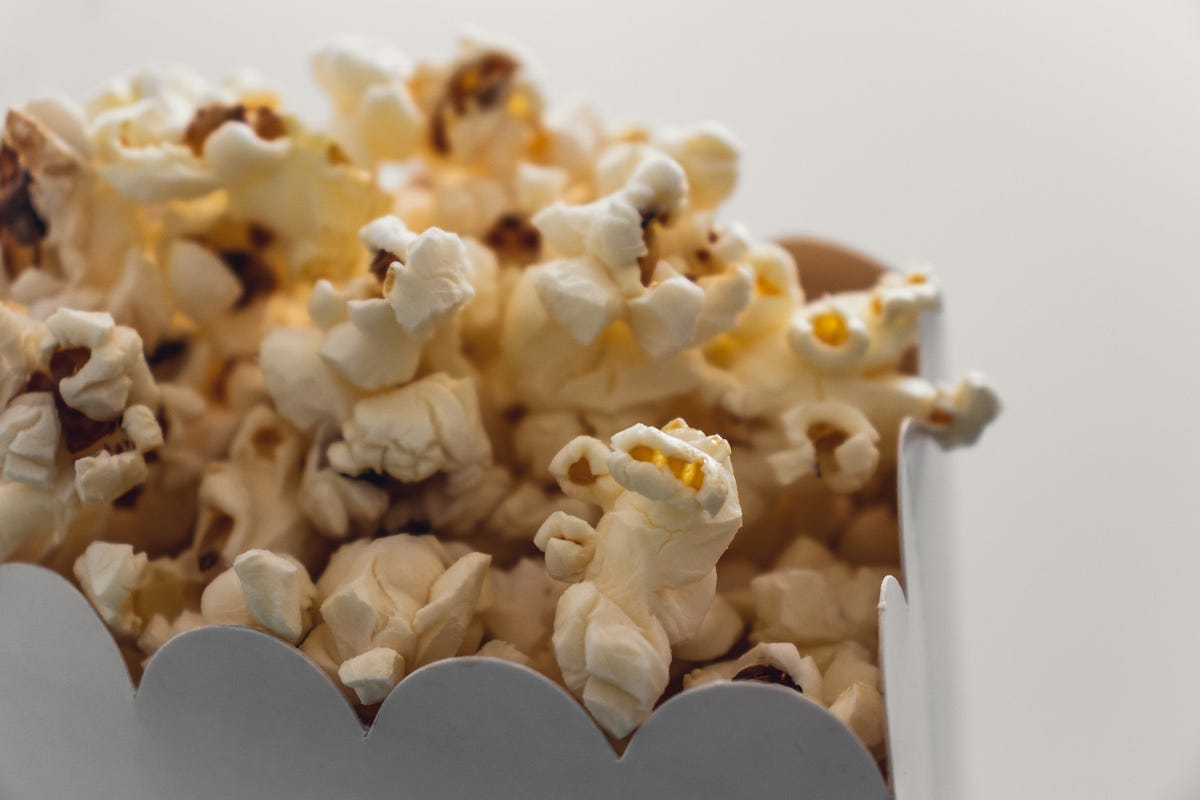

## Overview

For this project, we are using exploratory data analysis to generate insights from different sources and past movies data for  the business stakeholders.

## Business Problem

Microsoft has decided to create a new movie studio, is requesting recommendations for their product. We are tasked with exploring data on the market and translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

## Data

To answer the business questions, we utilized various data sets including the IMBD Database and then selected the following that have relevant factors such as ratings and genres of past movies to guide our insights and recommendations. We also used TheNumbers for profit analysis and Rotten Tomatoes datasets for movie runtimes. 

In [3]:
# starting imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure
import seaborn as sns 
pd.set_option('display.max_rows', 100) 
from matplotlib.ticker import StrMethodFormatter

In [4]:
#Loading in data from imdb file, rt and tn
tn_df = pd.read_csv('Data/tn.movie_budgets.csv.gz')
rt_info_df = pd.read_csv('Data/rt.movie_info.tsv.gz', delimiter='\t')

conn = sqlite3.connect('Data/im.db')
sql_tables = """
SELECT name FROM sqlite_master WHERE type='table'
"""
pd.read_sql(sql_tables, conn)

name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers

In [5]:
basics_df = pd.read_sql("""
SELECT *
FROM movie_basics
""", conn)

In [6]:
# previous cell shows a few nulls in original_title, several more in
# runtime_minutes and genras, I will potentially drop those


# two columns have numerical data, runtime_mines and start_year

# the range for start_year is from 2010 to 2115, which can mean incorrect 
# data or future releases
basics_df.describe()

start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000

In [7]:
# Exploring the movie_ratings table from the sql data, there are no nulls in this table
ratings_df = pd.read_sql("""
SELECT *
FROM movie_ratings

""", conn)

In [8]:
# removing significant figures
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# The mean rating is 6.3 and it looks like there are no incorrect entries
# the numvotes column looks like it has an outlier

ratings_df.describe()

averagerating      numvotes
count    73856.00000   73856.00000
mean         6.33273    3523.66217
std          1.47498   30294.02297
min          1.00000       5.00000
25%          5.50000      14.00000
50%          6.50000      49.00000
75%          7.40000     282.00000
max         10.00000 1841066.00000

### Data Preparation and Cleaning

We joined the movie_basics table that contains movie_id and genres and the movie_ratings table to analyze which genres were the most popular.

In [9]:
genres_ratings_df = pd.read_sql("""

SELECT mb.movie_id AS Movie_ID, mb.primary_title AS Title, mb.start_year AS Year, mb.genres AS Genre, mr.averagerating AS Rating, mr.numvotes AS Votes
FROM movie_basics AS mb
    JOIN movie_ratings AS mr
        ON mb.movie_id = mr.movie_id

""", conn)

In [10]:
genres_ratings_df

Movie_ID                            Title  Year                 Genre  \
0      tt0063540                        Sunghursh  2013    Action,Crime,Drama   
1      tt0066787  One Day Before the Rainy Season  2019       Biography,Drama   
2      tt0069049       The Other Side of the Wind  2018                 Drama   
3      tt0069204                  Sabse Bada Sukh  2018          Comedy,Drama   
4      tt0100275         The Wandering Soap Opera  2017  Comedy,Drama,Fantasy   
...          ...                              ...   ...                   ...   
73851  tt9913084                 Diabolik sono io  2019           Documentary   
73852  tt9914286                Sokagin Çocuklari  2019          Drama,Family   
73853  tt9914642                        Albatross  2017           Documentary   
73854  tt9914942       La vida sense la Sara Amat  2019                  None   
73855  tt9916160                       Drømmeland  2019           Documentary   

       Rating  Votes  
0     7.00000     77  
1     7.20000     43  
2     6.90000   4517  
3     6.10000     13  
4     6.50000    119  
...       ...    ...  
73851 6.20000      6  
73852 8.70000    136  
73853 8.50000      8  
73854 6.60000      5  
73855 6.50000     11  

[73856 rows x 6 columns]

In [11]:
# after join, since we didn't add the runtime column, there are only nulls in the Genre column
# there are now 73856 entries, as we merged on movie_id, the entries without id were not added

genres_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Movie_ID  73856 non-null  object 
 1   Title     73856 non-null  object 
 2   Year      73856 non-null  int64  
 3   Genre     73052 non-null  object 
 4   Rating    73856 non-null  float64
 5   Votes     73856 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.4+ MB


In [12]:
genres_ratings_df.isna().sum()

Movie_ID      0
Title         0
Year          0
Genre       804
Rating        0
Votes         0
dtype: int64

In [13]:
# dropping nulls in genre column
# total number of rows is now 73052

genres_ratings_df = genres_ratings_df.dropna(subset=['Genre'])

genres_ratings_df

Movie_ID                            Title  Year                 Genre  \
0      tt0063540                        Sunghursh  2013    Action,Crime,Drama   
1      tt0066787  One Day Before the Rainy Season  2019       Biography,Drama   
2      tt0069049       The Other Side of the Wind  2018                 Drama   
3      tt0069204                  Sabse Bada Sukh  2018          Comedy,Drama   
4      tt0100275         The Wandering Soap Opera  2017  Comedy,Drama,Fantasy   
...          ...                              ...   ...                   ...   
73850  tt9913056                     Swarm Season  2019           Documentary   
73851  tt9913084                 Diabolik sono io  2019           Documentary   
73852  tt9914286                Sokagin Çocuklari  2019          Drama,Family   
73853  tt9914642                        Albatross  2017           Documentary   
73855  tt9916160                       Drømmeland  2019           Documentary   

       Rating  Votes  
0     7.00000     77  
1     7.20000     43  
2     6.90000   4517  
3     6.10000     13  
4     6.50000    119  
...       ...    ...  
73850 6.20000      5  
73851 6.20000      6  
73852 8.70000    136  
73853 8.50000      8  
73855 6.50000     11  

[73052 rows x 6 columns]

In [14]:
# after merge and removing nulls, the year range is from 2010-2019

genres_ratings_df.groupby('Year').count()

Movie_ID  Title  Genre  Rating  Votes
Year                                       
2010      6701   6701   6701    6701   6701
2011      7274   7274   7274    7274   7274
2012      7602   7602   7602    7602   7602
2013      7905   7905   7905    7905   7905
2014      8269   8269   8269    8269   8269
2015      8405   8405   8405    8405   8405
2016      8613   8613   8613    8613   8613
2017      8638   8638   8638    8638   8638
2018      7476   7476   7476    7476   7476
2019      2169   2169   2169    2169   2169

In [15]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


genres_ratings_df.describe()

Year      Rating         Votes
count 73052.00000 73052.00000   73052.00000
mean   2014.28143     6.33093    3562.17263
std       2.61529     1.47470   30458.03757
min    2010.00000     1.00000       5.00000
25%    2012.00000     5.50000      14.00000
50%    2014.00000     6.50000      50.00000
75%    2017.00000     7.40000     289.00000
max    2019.00000    10.00000 1841066.00000

In [16]:
# there are no duplicate movie ids but possible duplicate names

genres_ratings_df.describe(include='object')

Movie_ID       Title  Genre
count       73052       73052  73052
unique      73052       69248    923
top     tt5306054  The Return  Drama
freq            1          11  11612

In [17]:
# creating new column for movies with multiple genres into a list 
# then we can use .explode() to break them 

genres_ratings_df['Genre'] = genres_ratings_df['Genre'].str.split(',')

<ipython-input-17-893b25ecdf7b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_ratings_df['Genre'] = genres_ratings_df['Genre'].str.split(',')


In [18]:
genres_ratings_df

Movie_ID                            Title  Year  \
0      tt0063540                        Sunghursh  2013   
1      tt0066787  One Day Before the Rainy Season  2019   
2      tt0069049       The Other Side of the Wind  2018   
3      tt0069204                  Sabse Bada Sukh  2018   
4      tt0100275         The Wandering Soap Opera  2017   
...          ...                              ...   ...   
73850  tt9913056                     Swarm Season  2019   
73851  tt9913084                 Diabolik sono io  2019   
73852  tt9914286                Sokagin Çocuklari  2019   
73853  tt9914642                        Albatross  2017   
73855  tt9916160                       Drømmeland  2019   

                          Genre  Rating  Votes  
0        [Action, Crime, Drama] 7.00000     77  
1            [Biography, Drama] 7.20000     43  
2                       [Drama] 6.90000   4517  
3               [Comedy, Drama] 6.10000     13  
4      [Comedy, Drama, Fantasy] 6.50000    119  
...                         ...     ...    ...  
73850             [Documentary] 6.20000      5  
73851             [Documentary] 6.20000      6  
73852           [Drama, Family] 8.70000    136  
73853             [Documentary] 8.50000      8  
73855             [Documentary] 6.50000     11  

[73052 rows x 6 columns]

In [19]:
# creating new column with first genre
genres_ratings_df['Genres1'] = genres_ratings_df['Genre'].apply(lambda x: x[0])
genres_ratings_df

<ipython-input-19-94f131fd23cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_ratings_df['Genres1'] = genres_ratings_df['Genre'].apply(lambda x: x[0])


Movie_ID                            Title  Year  \
0      tt0063540                        Sunghursh  2013   
1      tt0066787  One Day Before the Rainy Season  2019   
2      tt0069049       The Other Side of the Wind  2018   
3      tt0069204                  Sabse Bada Sukh  2018   
4      tt0100275         The Wandering Soap Opera  2017   
...          ...                              ...   ...   
73850  tt9913056                     Swarm Season  2019   
73851  tt9913084                 Diabolik sono io  2019   
73852  tt9914286                Sokagin Çocuklari  2019   
73853  tt9914642                        Albatross  2017   
73855  tt9916160                       Drømmeland  2019   

                          Genre  Rating  Votes      Genres1  
0        [Action, Crime, Drama] 7.00000     77       Action  
1            [Biography, Drama] 7.20000     43    Biography  
2                       [Drama] 6.90000   4517        Drama  
3               [Comedy, Drama] 6.10000     13       Comedy  
4      [Comedy, Drama, Fantasy] 6.50000    119       Comedy  
...                         ...     ...    ...          ...  
73850             [Documentary] 6.20000      5  Documentary  
73851             [Documentary] 6.20000      6  Documentary  
73852           [Drama, Family] 8.70000    136        Drama  
73853             [Documentary] 8.50000      8  Documentary  
73855             [Documentary] 6.50000     11  Documentary  

[73052 rows x 7 columns]

In [20]:
# converting 'Year' to str so it won't show in aggregate
genres_ratings_df['Year'] = genres_ratings_df['Year'].astype(str)

<ipython-input-20-86edcb3022ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_ratings_df['Year'] = genres_ratings_df['Year'].astype(str)


In [21]:
avg_rating_genre = genres_ratings_df.groupby('Genres1').mean().sort_values(by='Rating', ascending=False)
avg_rating_genre

Rating       Votes
Genres1                        
Game-Show   9.00000     7.00000
Music       7.50677   222.56771
Documentary 7.31660   213.03538
Biography   7.17451  5185.68424
Sport       6.94494    59.12360
Musical     6.63725   141.58824
History     6.41324    94.49265
Adventure   6.38671 10419.62519
Drama       6.37056  2198.86017
Animation   6.25239  2026.00624
Crime       6.15910  5287.37330
War         6.13404   117.76596
Mystery     6.09192  5495.54965
Romance     6.03690   594.29389
Family      6.02666   511.48841
Comedy      5.99851  2733.42078
Reality-TV  5.88000    23.00000
Action      5.81036 14476.48569
Thriller    5.70781   294.95713
Fantasy     5.67762  1409.43357
Sci-Fi      5.40026   669.92526
News        5.40000    10.75000
Western     5.03733   207.61333
Horror      4.85697  2368.81559
Adult       2.00000   128.00000

In [22]:
# num of movies per genre
movies_per_genre = genres_ratings_df.groupby('Genres1')['Movie_ID'].count()
avg_rating_genre['movies_per_genre'] = movies_per_genre
avg_rating_genre

Rating       Votes  movies_per_genre
Genres1                                          
Game-Show   9.00000     7.00000                 1
Music       7.50677   222.56771               192
Documentary 7.31660   213.03538             13962
Biography   7.17451  5185.68424              3433
Sport       6.94494    59.12360                89
Musical     6.63725   141.58824               153
History     6.41324    94.49265               136
Adventure   6.38671 10419.62519              2596
Drama       6.37056  2198.86017             18572
Animation   6.25239  2026.00624               962
Crime       6.15910  5287.37330              2494
War         6.13404   117.76596                47
Mystery     6.09192  5495.54965               433
Romance     6.03690   594.29389               786
Family      6.02666   511.48841               604
Comedy      5.99851  2733.42078             14649
Reality-TV  5.88000    23.00000                 5
Action      5.81036 14476.48569              6988
Thriller    5.70781   294.95713              1563
Fantasy     5.67762  1409.43357               429
Sci-Fi      5.40026   669.92526               388
News        5.40000    10.75000                 4
Western     5.03733   207.61333                75
Horror      4.85697  2368.81559              4490
Adult       2.00000   128.00000                 1

In [23]:
# filtering out genres with less than 1000 movies
# this list is the top rated genres with more than 1000 movies

avg_rating_genre2 = avg_rating_genre.loc[avg_rating_genre['movies_per_genre'] > 1000].sort_values(by='Rating', ascending=False)
avg_rating_genre2

Rating       Votes  movies_per_genre
Genres1                                          
Documentary 7.31660   213.03538             13962
Biography   7.17451  5185.68424              3433
Adventure   6.38671 10419.62519              2596
Drama       6.37056  2198.86017             18572
Crime       6.15910  5287.37330              2494
Comedy      5.99851  2733.42078             14649
Action      5.81036 14476.48569              6988
Thriller    5.70781   294.95713              1563
Horror      4.85697  2368.81559              4490

In [24]:
# looking at tn dataset for profit information
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [25]:
# Dropped the release date as it is not important to compare with production budget, domestic and worldwide gross.

updated_tn_df = tn_df.drop(columns=['release_date'])
updated_tn_df


# From here on out, we will replace the production_budget, domestic_gross, and worldwide_gross with integers as they 
# are currently strings. 
# We will do this to sort the values in ascending order from the least gross to the most of both domestic_gross and 
# worldwide_gross.

id                                        movie production_budget  \
0      1                                       Avatar      $425,000,000   
1      2  Pirates of the Caribbean: On Stranger Tides      $410,600,000   
2      3                                 Dark Phoenix      $350,000,000   
3      4                      Avengers: Age of Ultron      $330,600,000   
4      5            Star Wars Ep. VIII: The Last Jedi      $317,000,000   
...   ..                                          ...               ...   
5777  78                                       Red 11            $7,000   
5778  79                                    Following            $6,000   
5779  80                Return to the Land of Wonders            $5,000   
5780  81                         A Plague So Pleasant            $1,400   
5781  82                            My Date With Drew            $1,100   

     domestic_gross worldwide_gross  
0      $760,507,625  $2,776,345,279  
1      $241,063,875  $1,045,663,875  
2       $42,762,350    $149,762,350  
3      $459,005,868  $1,403,013,963  
4      $620,181,382  $1,316,721,747  
...             ...             ...  
5777             $0              $0  
5778        $48,482        $240,495  
5779         $1,338          $1,338  
5780             $0              $0  
5781       $181,041        $181,041  

[5782 rows x 5 columns]

In [26]:
# formatting 
updated_tn_df['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)
updated_tn_df['production_budget'] = updated_tn_df['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)

In [27]:
updated_tn_df['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(int)
updated_tn_df['domestic_gross'] = updated_tn_df['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(int)

In [28]:
updated_tn_df['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)
updated_tn_df['worldwide_gross'] = updated_tn_df['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)

In [29]:
# Now we will sort the values from descending order for the domestic_gross first and then the worldwide_gross
updated_tn_df.sort_values('domestic_gross', ascending=False)
updated_tn_df.sort_values('worldwide_gross', ascending=False)

id                                 movie  production_budget  \
0      1                                Avatar          425000000   
42    43                               Titanic          200000000   
5      6  Star Wars Ep. VII: The Force Awakens          306000000   
6      7                Avengers: Infinity War          300000000   
33    34                        Jurassic World          215000000   
...   ..                                   ...                ...   
5474  75                       Insomnia Manica             500000   
5473  74                       Girls Gone Dead             500000   
5472  73                         Enter Nowhere             500000   
5471  72                                Drones             500000   
4068  69                The Kings of Appletown            7000000   

      domestic_gross  worldwide_gross  
0          760507625 2776345279.00000  
42         659363944 2208208395.00000  
5          936662225 2053311220.00000  
6          678815482 2048134200.00000  
33         652270625 1648854864.00000  
...              ...              ...  
5474               0          0.00000  
5473               0          0.00000  
5472               0          0.00000  
5471               0          0.00000  
4068               0          0.00000  

[5782 rows x 5 columns]

In [30]:
# We will then create two additional columns to include the profit from domestic and the profit from worldwide. 
# We will also order them in ascending order for both columns
updated_tn_df['Profit from Domestic'] = updated_tn_df['domestic_gross'] - updated_tn_df['production_budget']
updated_tn_df['Profit from Worldwide'] = updated_tn_df['worldwide_gross'] - updated_tn_df['production_budget']
updated_tn_df.sort_values('Profit from Domestic', ascending=False)
updated_tn_df.sort_values('Profit from Worldwide', ascending=False)

id                                 movie  production_budget  \
0     1                                Avatar          425000000   
42   43                               Titanic          200000000   
6     7                Avengers: Infinity War          300000000   
5     6  Star Wars Ep. VII: The Force Awakens          306000000   
33   34                        Jurassic World          215000000   
..   ..                                   ...                ...   
352  53                        Town & Country          105000000   
341  42           Men in Black: International          110000000   
193  94                       Mars Needs Moms          150000000   
194  95                              Moonfall          150000000   
2     3                          Dark Phoenix          350000000   

     domestic_gross  worldwide_gross  Profit from Domestic  \
0         760507625 2776345279.00000             335507625   
42        659363944 2208208395.00000             459363944   
6         678815482 2048134200.00000             378815482   
5         936662225 2053311220.00000             630662225   
33        652270625 1648854864.00000             437270625   
..              ...              ...                   ...   
352         6712451   10364769.00000             -98287549   
341         3100000    3100000.00000            -106900000   
193        21392758   39549758.00000            -128607242   
194               0          0.00000            -150000000   
2          42762350  149762350.00000            -307237650   

     Profit from Worldwide  
0         2351345279.00000  
42        2008208395.00000  
6         1748134200.00000  
5         1747311220.00000  
33        1433854864.00000  
..                     ...  
352        -94635231.00000  
341       -106900000.00000  
193       -110450242.00000  
194       -150000000.00000  
2         -200237650.00000  

[5782 rows x 7 columns]

In [31]:
# looking at rt dataset for runtime info
rt_info_df

id                                           synopsis rating  \
0        1  This gritty, fast-paced, and innovative police...      R   
1        3  New York City, not-too-distant-future: Eric Pa...      R   
2        5  Illeana Douglas delivers a superb performance ...      R   
3        6  Michael Douglas runs afoul of a treacherous su...      R   
4        7                                                NaN     NR   
...    ...                                                ...    ...   
1555  1996  Forget terrorists or hijackers -- there's a ha...      R   
1556  1997  The popular Saturday Night Live sketch was exp...     PG   
1557  1998  Based on a novel by Richard Powell, when the l...      G   
1558  1999  The Sandlot is a coming-of-age story about a g...     PG   
1559  2000  Suspended from the force, Paris cop Hubert is ...      R   

                                                  genre            director  \
0                   Action and Adventure|Classics|Drama    William Friedkin   
1                     Drama|Science Fiction and Fantasy    David Cronenberg   
2                     Drama|Musical and Performing Arts      Allison Anders   
3                            Drama|Mystery and Suspense      Barry Levinson   
4                                         Drama|Romance      Rodney Bennett   
...                                                 ...                 ...   
1555   Action and Adventure|Horror|Mystery and Suspense                 NaN   
1556                 Comedy|Science Fiction and Fantasy        Steve Barron   
1557  Classics|Comedy|Drama|Musical and Performing Arts      Gordon Douglas   
1558    Comedy|Drama|Kids and Family|Sports and Fitness  David Mickey Evans   
1559  Action and Adventure|Art House and Internation...                 NaN   

                                                writer  theater_date  \
0                                       Ernest Tidyman   Oct 9, 1971   
1                         David Cronenberg|Don DeLillo  Aug 17, 2012   
2                                       Allison Anders  Sep 13, 1996   
3                      Paul Attanasio|Michael Crichton   Dec 9, 1994   
4                                         Giles Cooper           NaN   
...                                                ...           ...   
1555                                               NaN  Aug 18, 2006   
1556  Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner  Jul 23, 1993   
1557                                               NaN   Jan 1, 1962   
1558                  David Mickey Evans|Robert Gunter   Apr 1, 1993   
1559                                        Luc Besson  Sep 27, 2001   

          dvd_date currency  box_office      runtime             studio  
0     Sep 25, 2001      NaN         NaN  104 minutes                NaN  
1      Jan 1, 2013        $     600,000  108 minutes  Entertainment One  
2     Apr 18, 2000      NaN         NaN  116 minutes                NaN  
3     Aug 27, 1997      NaN         NaN  128 minutes                NaN  
4              NaN      NaN         NaN  200 minutes                NaN  
...            ...      ...         ...          ...                ...  
1555   Jan 2, 2007        $  33,886,034  106 minutes    New Line Cinema  
1556  Apr 17, 2001      NaN         NaN   88 minutes  Paramount Vantage  
1557  May 11, 2004      NaN         NaN  111 minutes                NaN  
1558  Jan 29, 2002      NaN         NaN  101 minutes                NaN  
1559  Feb 11, 2003      NaN         NaN   94 minutes  Columbia Pictures  

[1560 rows x 12 columns]

In [32]:
# copying my orignal dataframe to another dataframe
run_time = rt_info_df.copy()
# dropping the columns that I dont need.
remove_columns = ['synopsis', 'rating', 'writer', 'theater_date', 'dvd_date', 'currency', 'id', 'studio', 'director']
run_time.drop(columns=remove_columns, inplace=True)

In [33]:
# datacleaning
# dropping NA from box office and runtime
run_time.dropna(subset=['box_office'], inplace=True)
run_time.dropna(subset=['runtime'], inplace=True)
run_time

genre  box_office  \
1                    Drama|Science Fiction and Fantasy     600,000   
6                                               Comedy  41,032,915   
7                                                Drama     224,114   
8                                                Drama     134,904   
15                   Comedy|Drama|Mystery and Suspense   1,039,869   
...                                                ...         ...   
1541  Action and Adventure|Science Fiction and Fantasy  25,335,935   
1542                                      Comedy|Drama   1,416,189   
1545                       Horror|Mystery and Suspense      59,371   
1546          Art House and International|Comedy|Drama     794,306   
1555  Action and Adventure|Horror|Mystery and Suspense  33,886,034   

          runtime  
1     108 minutes  
6      82 minutes  
7     123 minutes  
8     117 minutes  
15    108 minutes  
...           ...  
1541  119 minutes  
1542  129 minutes  
1545   98 minutes  
1546   97 minutes  
1555  106 minutes  

[338 rows x 3 columns]

In [34]:
# stripping minutes(unit) off from runtime column
run_time['runtime']=run_time['runtime'].str.strip(' minutes')
run_time['runtime'] = (run_time['runtime'].astype(int))
run_time

genre  box_office  runtime
1                    Drama|Science Fiction and Fantasy     600,000      108
6                                               Comedy  41,032,915       82
7                                                Drama     224,114      123
8                                                Drama     134,904      117
15                   Comedy|Drama|Mystery and Suspense   1,039,869      108
...                                                ...         ...      ...
1541  Action and Adventure|Science Fiction and Fantasy  25,335,935      119
1542                                      Comedy|Drama   1,416,189      129
1545                       Horror|Mystery and Suspense      59,371       98
1546          Art House and International|Comedy|Drama     794,306       97
1555  Action and Adventure|Horror|Mystery and Suspense  33,886,034      106

[338 rows x 3 columns]

In [35]:
# cleaning box_office values.

def clean_a_money_column(df, series_title):
    
    df[series_title] = df[series_title].astype(str).str.replace('$','')
    df[series_title] = df[series_title].astype(str).str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df

run_time = clean_a_money_column(run_time,'box_office')
display(run_time)

genre  box_office  runtime
1                    Drama|Science Fiction and Fantasy      600000      108
6                                               Comedy    41032915       82
7                                                Drama      224114      123
8                                                Drama      134904      117
15                   Comedy|Drama|Mystery and Suspense     1039869      108
...                                                ...         ...      ...
1541  Action and Adventure|Science Fiction and Fantasy    25335935      119
1542                                      Comedy|Drama     1416189      129
1545                       Horror|Mystery and Suspense       59371       98
1546          Art House and International|Comedy|Drama      794306       97
1555  Action and Adventure|Horror|Mystery and Suspense    33886034      106

[338 rows x 3 columns]

In [36]:
# looking at only the top 50 movies
top_50_movies=run_time['box_office'].value_counts()[0:50]
run_time.sort_values(by='runtime', ascending=True, inplace=True)

In [37]:
def bin_helper(runtime):
    if runtime < 100:
        return '0-99'
    elif runtime > 140:
        return '140+'
    else:
        return '100-140'

In [38]:
run_time['run_time_binned']= run_time['runtime'].map(bin_helper)

In [39]:
#median of runtime
rn_grouped = run_time.groupby('run_time_binned').median()
rn_grouped

box_office  runtime
run_time_binned                     
0-99               12883277       91
100-140            18602895      114
140+                6100613      157

## Results

### Recommendation 1

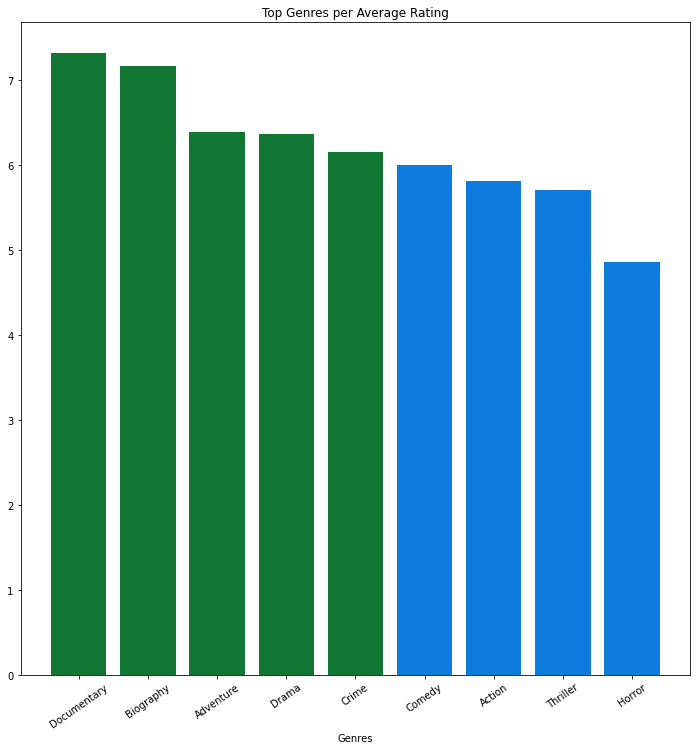

In [40]:
figure, ax = plt.subplots(figsize=(12, 12))

color = ['#117733','#117733','#117733','#117733','#117733', '#0C7BDC', '#0C7BDC', '#0C7BDC', '#0C7BDC']
# color palates for color blindness:
# https://davidmathlogic.com/colorblind/#%23332288-%23117733-%235FA599-%233EA6DA-%23DDCC77-%23CC6677-%23AA4499-%23882255

ax.bar(x = avg_rating_genre2.index , height = avg_rating_genre2['Rating'],
                                       color = color )
ax.set_title('Top Genres per Average Rating')
ax.set_xlabel('Genres')

plt.xticks(rotation = 35 )

plt.savefig('Images/top_genres.png', dpi=300);


### Recommendation 2

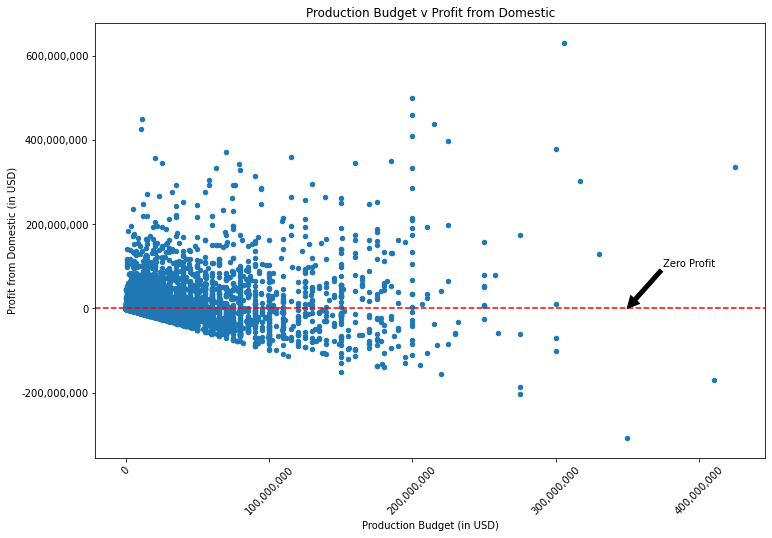

In [41]:
updated_tn_df.plot(x='production_budget', y='Profit from Domestic', kind='scatter', figsize=(12,8))

plt.xticks(rotation=45)

plt.xlabel('Production Budget (in USD)')
plt.ylabel('Profit from Domestic (in USD)')
plt.title('Production Budget v Profit from Domestic')

plt.ticklabel_format(style='plain', axis='both', useMathText=True)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.axhline(y=0, color='red', linestyle='--')
plt.annotate('Zero Profit', xy=(350000000,0), xytext=(375000000, 100000000), arrowprops={'facecolor': 'black'})


plt.savefig('Images/Budget_vs_domestic_profit.png', dpi=300);

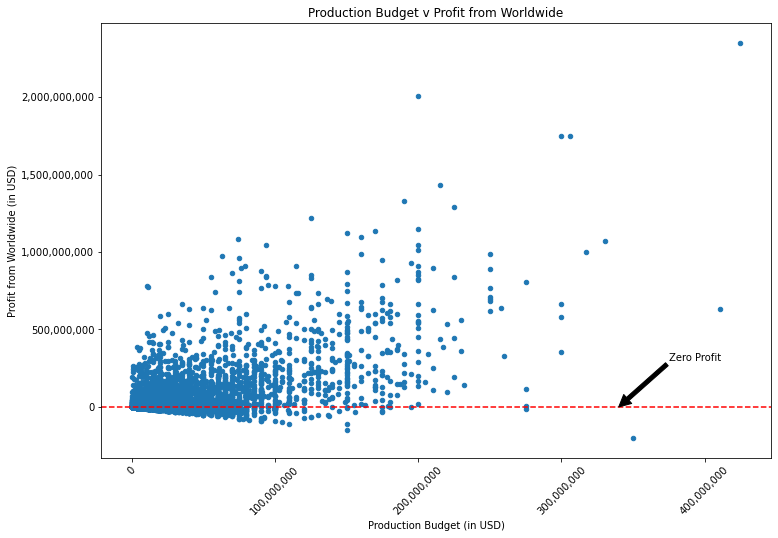

In [42]:
updated_tn_df.plot(x='production_budget', y='Profit from Worldwide', kind='scatter', figsize=(12,8))

plt.xticks(rotation=45)

plt.xlabel('Production Budget (in USD)')
plt.ylabel('Profit from Worldwide (in USD)')
plt.title('Production Budget v Profit from Worldwide')

plt.ticklabel_format(style='plain', axis='both', useMathText=True)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.axhline(y=0, color='red', linestyle='--')
plt.annotate('Zero Profit', xy=(340000000,0), xytext=(375000000, 300000000), arrowprops={'facecolor': 'black'})

plt.savefig('Images/Budget_vs_worldwide_profit.png', dpi=300);

In [43]:
# At last, we will compute the mean for both profit from domestic and the profit from worldwide.
mean1 = updated_tn_df['Profit from Domestic'].mean()
mean2 = updated_tn_df['Profit from Worldwide'].mean()

AttributeError: This method only works with the ScalarFormatter

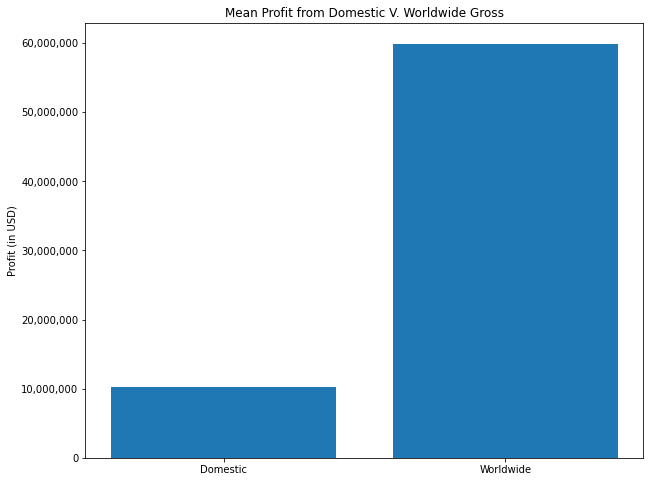

In [44]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(['Domestic', 'Worldwide'], [mean1, mean2])

ax.set_title('Mean Profit from Domestic V. Worldwide Gross')
ax.set_ylabel('Profit (in USD)')

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.ticklabel_format(style='plain', axis='y', useOffset=False)


plt.savefig('Images/Domestic_vs_Worldwide_mean.png', dpi=300);

### Recommendation 3

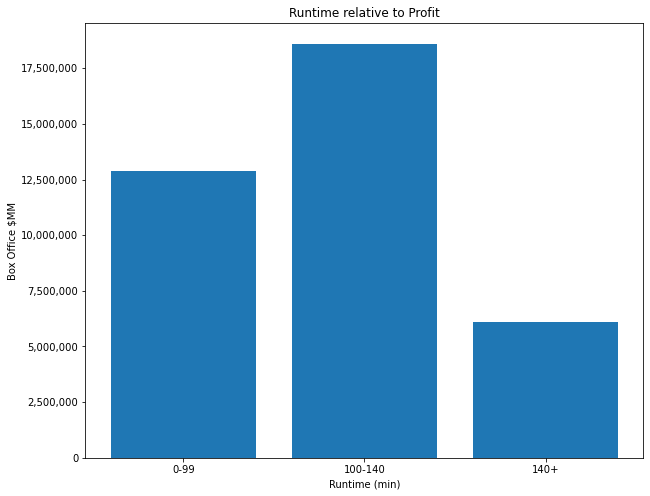

In [46]:
#scatter plot of relationship between runtime and boxoffice profit.

x= rn_grouped.index
y= rn_grouped['box_office']
fig, ax = plt.subplots(figsize = (10,8))
plt.ticklabel_format(style='plain')

ax.bar(x,y)
ax.set_title('Runtime relative to Profit')
ax.set_xlabel('Runtime (min)')
ax.set_ylabel('Box Office $MM')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.savefig('Images/Runtime_vs_profit.png', dpi=300);

## Conclusion And Recommendations

- Based on the information in the data sets, we can see the highest rated genres are Documentary, Biography, Adventure, Drama, Crime, Comedy, Action, Thriller and Horror. We recommend venturing into those fields as we explore what types of movies to make at Microsof's new studio.
- In order to breakout into the movie scene by creating a new movie studio, Microsoft must expand into foreign markets as well as there is a better profit margin in international markets than just domestically in the United States.There is about a $50 million dollar difference in mean profit between international movies than just domestic movies alone.On top of that, the highest grossing movies with the most profit are franchise movies such as "Marvel Studios", "The Fast & The Furious Saga", "The Star Wars Saga", & "The Harry Potter Movies". It is imperative for Microsoft to start a movie studio based on a franchise that movie fans can really get behind.
- Based on the above analysis the movies that have made the most profit are not very long nor are they very short. Most successfull movies at box office have runtime between 100-140 minutes.

## Next Steps

This dataset looks at movie information from 2010-2019. As seen on the graph, some genres that have been popular in the last few years such as **Action** and **Comedy** are on the lower end of the spectrum and is worth considering other measures in addition to genre to determine not just volume, but the profits involved in those genres. Profit, ROI or gross were not included in this dataset.
